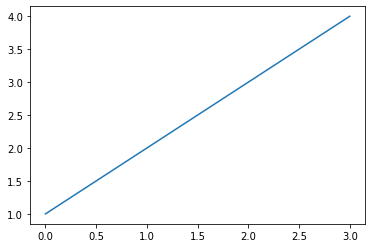

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot([1,2,3,4])

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
import lightgbm
pd.set_option('use_inf_as_na', True)
from collections import Counter
import pickle

import optuna
from optuna.trial import Trial
import optuna.integration.lightgbm as lgb


from lightgbm import LGBMClassifier
from lightgbm import early_stopping
from lightgbm import log_evaluation
import sklearn.datasets
from sklearn.model_selection import train_test_split

from functools import partial

In [3]:
from lightgbm import log_evaluation

In [4]:
raw_data = pd.read_pickle(r'C:\Users\niels\OneDrive\Machine Learning 2022\Lecture 2\dataset.pkl')
data = raw_data[raw_data['market_cap'] > 1000.0]
data = data.copy()
data.fillna(0.0,inplace=True)

In [5]:
def f(x):
    if x > 0.01:
        return 1
    elif x < -0.025:
        return -1
    else:
    
        return 0

In [6]:
data['rel_performance'] = data['pred_rel_return'].apply(f)
data.reset_index(inplace=True)
data.set_index('date',inplace=True)

In [7]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
scaler = StandardScaler()

## Long term performance with AdaBoost Classifier, optimal hyper-parameters

In [8]:
start_dates = [pd.to_datetime('2001-01-01') + pd.DateOffset(months = 3*i) for i in range(57)]
end_dates = [d + pd.DateOffset(months = 36) for d in start_dates]

In [9]:
training_frames = [data.loc[d:d+pd.DateOffset(months = 36)] for d in start_dates]
valid_frames = [data.loc[d:d+pd.DateOffset(months = 3)] for d in end_dates]
test_frames = [data.loc[d+pd.DateOffset(months = 6):d+pd.DateOffset(months = 9)] for d in end_dates]

In [10]:
training_data = [d.reset_index().drop
                                 (['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in training_frames]

In [11]:
valid_data = [d.reset_index().drop
                                 (['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in valid_frames]

In [12]:
test_data = [d.reset_index().drop(['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in test_frames]

In [13]:
training_labels = [d['rel_performance'].values for d in training_frames]
valid_labels = [d['rel_performance'].values for d in valid_frames] 

In [14]:
for i in range(len(start_dates)-1):
    float_vars = [x for x in training_data[i].columns if data[x].dtype == 'float64']

    scaler = StandardScaler()
    training_data[i] = training_data[i].copy()
    valid_data[i] = valid_data[i].copy()
    test_data[i] = test_data[i].copy()
    training_data[i][float_vars] = scaler.fit_transform(training_data[i][float_vars])
    valid_data[i][float_vars] = scaler.transform(valid_data[i][float_vars])
    test_data[i][float_vars] = scaler.transform(test_data[i][float_vars])
        
    

In [16]:
import optuna
from optuna.trial import Trial
optuna.logging.set_verbosity(optuna.logging.FATAL)
import warnings
warnings.filterwarnings("ignore")

In [17]:
def objective(trial:Trial,train=None,labels=None,val=None,val_labels=None,val_rets=None):
    
    params = {
        "objective": "multiclass",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "n_estimators":trial.suggest_int('n_estimators',10,100,step=10),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 5, 25),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf',400,2400,step=400),
        'learning_rate': trial.suggest_float('learning_rate',0.01,0.2,step=0.01)
    }
    
    gb_clf = LGBMClassifier(**params)
    gbm = gb_clf.fit(train,labels)
    preds = gbm.predict(val)
    profit = (preds*val_rets).sum()
    return profit


In [15]:
optimal_hyperparameters = []

In [19]:
for i in range(len(start_dates)-1):
    
    study = optuna.create_study(direction="maximize")
    
    study.optimize(partial(objective,
                           train=training_data[i],
                           labels=training_labels[i],
                           val=valid_data[i],
                           val_labels=valid_labels[i],
                           val_rets=valid_frames[i]['next_period_return']), n_trials=25,n_jobs=-1)
    
    optimal_hyperparameters.append(study.best_params)  
    print(study.best_params)
    

{'n_estimators': 70, 'reg_lambda': 1.2933640992521154, 'num_leaves': 17, 'min_data_in_leaf': 400, 'learning_rate': 0.09999999999999999}
{'n_estimators': 40, 'reg_lambda': 0.00028455163202996755, 'num_leaves': 18, 'min_data_in_leaf': 400, 'learning_rate': 0.16}
{'n_estimators': 40, 'reg_lambda': 0.00010867307783582423, 'num_leaves': 12, 'min_data_in_leaf': 1600, 'learning_rate': 0.01}
{'n_estimators': 10, 'reg_lambda': 1.246871610115909, 'num_leaves': 14, 'min_data_in_leaf': 2400, 'learning_rate': 0.19}
{'n_estimators': 80, 'reg_lambda': 0.5470426439402686, 'num_leaves': 11, 'min_data_in_leaf': 1600, 'learning_rate': 0.2}
{'n_estimators': 10, 'reg_lambda': 3.973909407154452e-07, 'num_leaves': 24, 'min_data_in_leaf': 1600, 'learning_rate': 0.05}
{'n_estimators': 50, 'reg_lambda': 0.0007676774985477343, 'num_leaves': 25, 'min_data_in_leaf': 400, 'learning_rate': 0.2}
{'n_estimators': 70, 'reg_lambda': 0.06496226034573477, 'num_leaves': 16, 'min_data_in_leaf': 1600, 'learning_rate': 0.02}


In [16]:
import pickle

In [20]:
with open(r'optimal_hyperparameters_gb_01.pkl','wb') as f:
    pickle.dump(optimal_hyperparameters,f)

In [17]:
with open(r'optimal_hyperparameters_gb_01.pkl','rb') as f:
    optimal_hyperparameters = pickle.load(f)

In [18]:
optimal_hyperparameters

[{'n_estimators': 70,
  'reg_lambda': 1.2933640992521154,
  'num_leaves': 17,
  'min_data_in_leaf': 400,
  'learning_rate': 0.09999999999999999},
 {'n_estimators': 40,
  'reg_lambda': 0.00028455163202996755,
  'num_leaves': 18,
  'min_data_in_leaf': 400,
  'learning_rate': 0.16},
 {'n_estimators': 40,
  'reg_lambda': 0.00010867307783582423,
  'num_leaves': 12,
  'min_data_in_leaf': 1600,
  'learning_rate': 0.01},
 {'n_estimators': 10,
  'reg_lambda': 1.246871610115909,
  'num_leaves': 14,
  'min_data_in_leaf': 2400,
  'learning_rate': 0.19},
 {'n_estimators': 80,
  'reg_lambda': 0.5470426439402686,
  'num_leaves': 11,
  'min_data_in_leaf': 1600,
  'learning_rate': 0.2},
 {'n_estimators': 10,
  'reg_lambda': 3.973909407154452e-07,
  'num_leaves': 24,
  'min_data_in_leaf': 1600,
  'learning_rate': 0.05},
 {'n_estimators': 50,
  'reg_lambda': 0.0007676774985477343,
  'num_leaves': 25,
  'min_data_in_leaf': 400,
  'learning_rate': 0.2},
 {'n_estimators': 70,
  'reg_lambda': 0.0649622603457

In [22]:
classifiers = []

In [24]:
for hyp_par in optimal_hyperparameters:
    gb_clf = LGBMClassifier(**hyp_par)
    classifiers.append(gb_clf)

In [25]:
for i in range(len(start_dates)-1): 
    classifiers[i].fit(training_data[i],training_labels[i])

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


In [26]:
with open(r'classifiers_gb_clf_01.pkl','wb') as f:
    pickle.dump(classifiers,f)

In [19]:
with open(r'classifiers_gb_clf_01.pkl','rb') as f:
    classifiers = pickle.load(f)

In [20]:
def gbm_feat_importances(m, df):
        
    return pd.DataFrame({'cols':df.columns, 'feat_imp': m.feature_importances_}
                       ).sort_values('feat_imp', ascending=False)

In [21]:
%%time
significant_features = []
for i in range(len(start_dates)-1):

    fi = gbm_feat_importances(classifiers[i],training_data[i])
    features = fi[fi['feat_imp'] > 0]
    significant_features.append(features)

CPU times: total: 31.2 ms
Wall time: 90.6 ms


In [22]:
significant_features[11]

,cols,feat_imp
102,oancfy_q,32
156,fcf_yield,28
90,book_value_per_share,20
104,cfo-per-share,20
179,fqtr_1,16
86,dvpspq,16
105,cf_yield,12
107,dvq,12
162,de_ratioq,12
160,debt_assetsq,9


In [23]:
with open(r'significant_features_gb_clf_01.pkl','wb') as f:
    pickle.dump(significant_features,f)

In [24]:
new_training_data = []
new_valid_data = []
new_test_data = []

In [25]:
for i in range(len(start_dates)-1): 
    new_training_data.append(training_data[i][significant_features[i]['cols']])
    new_valid_data.append(valid_data[i][significant_features[i]['cols']])
    new_test_data.append(test_data[i][significant_features[i]['cols']])
    

In [26]:
for i in range(len(start_dates)-1):
    float_vars = [x for x in new_training_data[i].columns if data[x].dtype == 'float64']

    scaler = StandardScaler()
    new_training_data[i] = new_training_data[i].copy()
    new_valid_data[i] = new_valid_data[i].copy()
    new_test_data[i] = new_test_data[i].copy()
    new_training_data[i][float_vars] = scaler.fit_transform(new_training_data[i][float_vars])
    new_valid_data[i][float_vars] = scaler.transform(new_valid_data[i][float_vars])
    new_test_data[i][float_vars] = scaler.transform(new_test_data[i][float_vars])

In [65]:
for i in range(len(start_dates)-1): 
    classifiers[i].fit(new_training_data[i],training_labels[i])

In [66]:
with open(r'new_classifiers_gb_clf_01.pkl','wb') as f:
    pickle.dump(classifiers,f)

In [32]:
with open(r'new_classifiers_gb_clf_01.pkl','rb') as f:
    classifiers = pickle.load(f)

In [31]:
def model(features):
    tree_features = features[features.columns[:-1].values]

    pred = gb_clf.predict(tree_features)

    ret = pred * features[features.columns[-1]]

    return ret

In [28]:
import shap

In [29]:
shap_features = []

In [33]:
for i in range(len(start_dates)-1):
    valid_1 = new_valid_data[i].copy()
    cols = new_valid_data[i].columns
    print(len(cols))
    valid_1['rets'] = valid_frames[i]['next_period_return'].values
    gb_clf = classifiers[i]
    explainer = shap.explainers.Permutation(model,valid_1)
    shap_values = explainer(valid_1,max_evals=500,)
    shap_cols = cols[np.abs(shap_values[:,:-1].values).mean(axis=0)>0.000]
    if shap_cols.empty:
        shap_cols = cols[:10]
    print(len(shap_cols))
    shap_features.append(shap_cols)
    

179


Permutation explainer: 1123it [10:06,  1.83it/s]                                                                       


179
177


Permutation explainer: 1156it [08:17,  2.28it/s]                                                                       


175
36


Permutation explainer: 1174it [03:12,  5.77it/s]                                                                       


10
41


Permutation explainer: 1137it [02:13,  7.84it/s]                                                                       


10
161


Permutation explainer: 1266it [07:37,  2.71it/s]                                                                       


151
43


Permutation explainer: 1261it [02:40,  7.31it/s]                                                                       


10
184


Permutation explainer: 1256it [09:02,  2.27it/s]                                                                       


184
94


Permutation explainer: 1284it [06:01,  3.43it/s]                                                                       


2
78


Permutation explainer: 1316it [04:47,  4.40it/s]                                                                       


10
188


Permutation explainer: 1414it [13:20,  1.75it/s]                                                                       


188
48


Permutation explainer: 1361it [03:58,  5.43it/s]                                                                       


10
22


Permutation explainer: 1355it [02:08,  9.73it/s]                                                                       


10
137


Permutation explainer: 1475it [04:58,  4.76it/s]                                                                       


61
178


Permutation explainer: 1512it [10:49,  2.29it/s]                                                                       


175
154


Permutation explainer: 1523it [08:09,  3.04it/s]                                                                       


133
187


Permutation explainer: 1499it [11:44,  2.10it/s]                                                                       


186
127


Permutation explainer: 1455it [06:44,  3.50it/s]                                                                       


109
191


Permutation explainer: 1400it [11:17,  2.04it/s]                                                                       


190
191


Permutation explainer: 1376it [13:06,  1.72it/s]                                                                       


190
186


Permutation explainer: 1301it [07:16,  2.91it/s]                                                                       


170
42


Permutation explainer: 1099it [02:16,  7.50it/s]                                                                       


10
52


Permutation explainer: 1029it [02:24,  6.58it/s]                                                                       


10
22


Permutation explainer: 1180it [01:34, 11.21it/s]                                                                       


8
151


Permutation explainer: 1279it [06:52,  3.03it/s]                                                                       


93
101


Permutation explainer: 1353it [06:52,  3.19it/s]                                                                       


68
189


Permutation explainer: 1442it [12:42,  1.87it/s]                                                                       


189
20


Permutation explainer: 1388it [01:48, 11.61it/s]                                                                       


7
58


Permutation explainer: 1443it [06:02,  3.87it/s]                                                                       


10
43


Permutation explainer: 1554it [02:57,  8.26it/s]                                                                       


15
191


Permutation explainer: 1547it [14:41,  1.73it/s]                                                                       


191
181


Permutation explainer: 1612it [09:36,  2.75it/s]                                                                       


171
82


Permutation explainer: 1426it [04:35,  4.96it/s]                                                                       


10
188


Permutation explainer: 1528it [09:04,  2.76it/s]                                                                       


187
191


Permutation explainer: 1610it [14:39,  1.81it/s]                                                                       


191
53


Permutation explainer: 1619it [04:40,  5.57it/s]                                                                       


4
39


Permutation explainer: 1531it [03:58,  6.14it/s]                                                                       


10
44


Permutation explainer: 1625it [03:34,  7.16it/s]                                                                       


4
18


Permutation explainer: 1751it [02:23, 11.36it/s]                                                                       


10
76


Permutation explainer: 1802it [06:39,  4.40it/s]                                                                       


10
171


Permutation explainer: 1875it [13:47,  2.24it/s]                                                                       


166
49


Permutation explainer: 1957it [04:27,  6.96it/s]                                                                       


31
30


Permutation explainer: 1969it [06:03,  5.25it/s]                                                                       


9
167


Permutation explainer: 2061it [13:38,  2.49it/s]                                                                       


146
123


Permutation explainer: 1973it [09:55,  3.25it/s]                                                                       


103
32


Permutation explainer: 2042it [06:32,  5.04it/s]                                                                       


17
166


Permutation explainer: 2081it [16:08,  2.13it/s]                                                                       


154
193


Permutation explainer: 2136it [24:24,  1.45it/s]                                                                       


193
187


Permutation explainer: 1949it [19:21,  1.67it/s]                                                                       


187
59


Permutation explainer: 1965it [07:17,  4.37it/s]                                                                       


44
39


Permutation explainer: 1951it [05:53,  5.36it/s]                                                                       


10
184


Permutation explainer: 2006it [15:41,  2.11it/s]                                                                       


182
14


Permutation explainer: 2006it [03:36,  8.83it/s]                                                                       


12
34


Permutation explainer: 2067it [04:21,  7.59it/s]                                                                       


10
134


Permutation explainer: 2109it [09:04,  3.80it/s]                                                                       


105
51


Permutation explainer: 2155it [04:55,  6.99it/s]                                                                       


10
29


Permutation explainer: 2155it [04:44,  7.30it/s]                                                                       


10


In [34]:
with open(r'shap_features_gb_clf_01.pkl','wb') as f:
    pickle.dump(shap_features,f)

In [35]:
with open(r'shap_features_gb_clf_01.pkl','rb') as f:
    shap_features = pickle.load(f)

In [36]:
shap_features[10]

Index(['oancfy_q', 'cf_yield', 'de_ratioq', 'xsgay', 'cshiq', 'debt_atq',
       'opmadq', 'oepsxy', 'lagppent4', 'epspxq'],
      dtype='object')

In [55]:
start_dates = [pd.to_datetime('2001-01-01') + pd.DateOffset(months = 3*i) for i in range(57)]
end_dates = [d + pd.DateOffset(months = 39) for d in start_dates]

In [56]:
training_frames = [data.loc[d:d+pd.DateOffset(months = 39)] for d in start_dates]
test_frames = [data.loc[d+pd.DateOffset(months = 3):d+pd.DateOffset(months = 6)] for d in end_dates]

In [57]:
scalers = [StandardScaler() for i in range(len(start_dates)-1)]
           
opt_training_data = [pd.DataFrame(scalers[i].fit_transform(training_frames[i][shap_features[i]].values),columns=shap_features[i]) for i in range(len(start_dates)-1)]
opt_test_data = [pd.DataFrame(scalers[i].transform(test_frames[i][shap_features[i]].values),columns=shap_features[i]) for i in range(len(start_dates)-1)]

In [58]:
training_labels = [d['rel_performance'].values for d in training_frames]

In [59]:
x = [1]
ret = []

for i in range(len(start_dates)-1):
        
        classifiers[i].fit(opt_training_data[i],training_labels[i])

        preds = classifiers[i].predict(opt_test_data[i])
        profit_i = (preds*test_frames[i]['next_period_return']).sum()
        ret.append(profit_i)
        num_names = len(opt_test_data[i])
        x.append(x[i] + (x[i]/num_names)*profit_i)

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=1600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1600
[LightGBM] [Warning] min_data_in_leaf is set=2400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2400
[LightGBM] [Warning] min_data_in_leaf is set=1600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1600
[LightGBM] [Warning] min_data_in_leaf is set=1600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1600
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=1600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=160

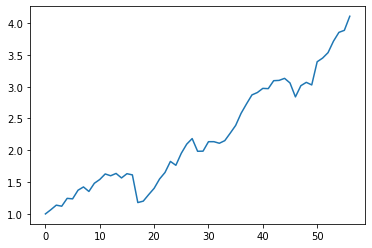

In [60]:
plt.plot(x);

In [30]:
len(x)

57

In [61]:
SPY = pd.read_pickle(r'C:\Users\niels\OneDrive\Machine Learning 2022\Lecture 2\SPY_cum_ret.pkl')
SPY = SPY.loc['2004-09-01':'2018-09-30']
SPY = SPY.resample('Q').ffill()
SPY['spy_cum_ret'] = (SPY['spy_cum_ret'] - SPY['spy_cum_ret'][0] + 1)
SPY['strategy'] = x

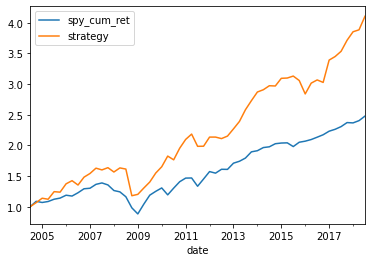

In [62]:
SPY.plot();

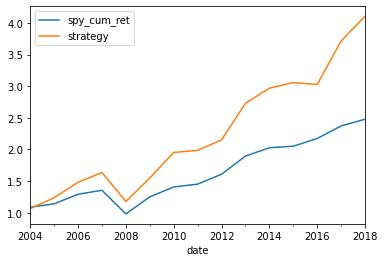

In [63]:
SPY = SPY.resample('Y').ffill()
SPY.plot();

In [64]:
with open(r'gb_strategy.pkl','wb') as f:
    pickle.dump(SPY['strategy'],f)

In [65]:
strategy_mean_ret = (SPY['strategy'] - 1).diff().mean()
strategy_std = (SPY['strategy'] - 1).diff().std()
strategy_sr = strategy_mean_ret/strategy_std
print('Strategy Sharpe Ratio: ',strategy_sr)

Strategy Sharpe Ratio:  0.7762064255829813


In [66]:
x[-1]

4.106900807540151

In [67]:
SPY['spy_cum_ret'][-1]

2.4779340000000003

In [68]:
strategy_ret = (SPY['strategy'] - 1).diff().values[1:]
spy_ret = (SPY['spy_cum_ret'] - 1).diff().values[1:]

In [69]:
beta = (np.cov(spy_ret,strategy_ret)/np.var(spy_ret))[1,0]

In [70]:
beta 

1.6426685220054509

In [144]:
SPY['hedge'] = SPY['strategy'] - 1.54*(SPY['spy_cum_ret'])+1.54

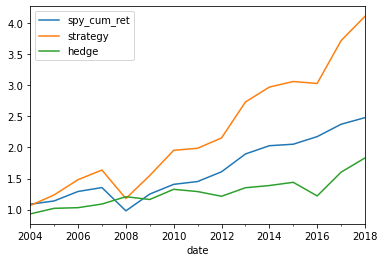

In [145]:
SPY.plot();

In [146]:
hedge_ret = (SPY['hedge'] - 1).diff().values[1:]

In [158]:
SPY['hedge'][-1]

1.8308824475401502

In [159]:
SPY['hedge'].std()

0.2335612610267228

In [147]:
beta_hedge = (np.cov(spy_ret,hedge_ret)/np.var(spy_ret))[1,0]

In [148]:
beta_hedge

-0.01579301645608734

In [149]:
hedge_mean_ret = (SPY['hedge'] - 1).diff().mean()
hedge_std = (SPY['hedge'] - 1).diff().std()
hedge_sr = hedge_mean_ret/hedge_std
print('Hedge Sharpe Ratio: ',strategy_sr)

Hedge Sharpe Ratio:  0.7762064255829813


Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.


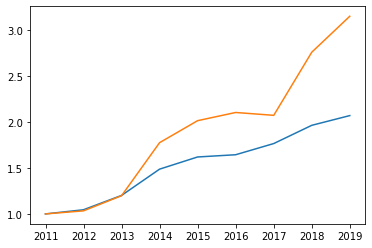

In [150]:
starting_year='2010'
a = SPY.loc[starting_year]['spy_cum_ret'].values
b = SPY[starting_year]['strategy'].values
plt.plot(SPY.loc[starting_year:]['spy_cum_ret'] - a + 1);
plt.plot(SPY.loc[starting_year:]['strategy'] - b + 1);

In [155]:
combined = 5*(SPY.loc['2010':]['hedge']+1.54)

In [152]:
combined[0]=1

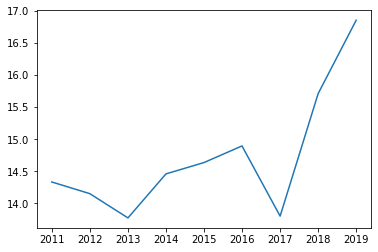

In [156]:
plt.plot(combined)